# Data processing

# Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from constants import RANDOM_FOREST_PARAMS, NUM_SELECTED, CAT_SELECTED, SELECTED_FEATURES

from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

from dask import delayed, compute
from dask.diagnostics import ProgressBar

from skopt.space import Integer
from skopt import gp_minimize

from tqdm import tqdm

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

from category_encoders import BinaryEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

import optuna
from optuna.samplers import TPESampler
from xgboost import XGBClassifier
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

# Data Loading

In [3]:
X_list = []
y_list = []

X_train = pd.read_parquet("../../../../../data/interim/copper/X_train.parquet")
y_train = pd.read_parquet("../../../../../data/interim/copper/y_train_cat.parquet")
X_test = pd.read_parquet("../../../../../data/interim/copper/X_test_rf.parquet")

# Tunning with PCA

## Setting Up Pipeline Steps

In [4]:
NUM_SELECTED = ['COPPER_GRADE', 'LOG_10_COPPER_GRADE', 'INITIAL_COST', 'LOG_10_INITIAL_COST_PER_TONNE',
       'INITIAL_COST_PER_TONNE', 'LOG_10_GOLD_DENSITY', 'GOLD_DENSITY']

CAT_SELECTED = ["GLOBAL_REGION"]

# Components Selection

In [6]:
over = SMOTE(sampling_strategy="auto")
under = RandomUnderSampler(sampling_strategy="auto")

numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('imputer', KNNImputer(n_neighbors=5)),
        ( 'pca', PCA(n_components=len(NUM_SELECTED)))
    ])

categorical_transformer = Pipeline(steps=[
    ('binary_encoder', BinaryEncoder())
])

preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, NUM_SELECTED),
            ('cat', categorical_transformer, ["GLOBAL_REGION"])
        ]
    )

def preprocessor(X, y):
    
    over = SMOTE(sampling_strategy="auto")
    under = RandomUnderSampler(sampling_strategy="auto")

    numeric_transformer = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('imputer', KNNImputer(n_neighbors=5)),
            ( 'pca', PCA(n_components=len(NUM_SELECTED)))
        ])

    categorical_transformer = Pipeline(steps=[
        ('binary_encoder', BinaryEncoder())
    ])

    preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, NUM_SELECTED),
                ('cat', categorical_transformer, CAT_SELECTED)
            ]
        )
    
    X_pross = preprocessor.fit_transform(X)

    over = SMOTE(sampling_strategy="auto", random_state=42)
    X_res, y_res = over.fit_resample(X_pross, y)
        
    under = RandomUnderSampler(sampling_strategy="auto", random_state=42)
    X_res, y_res = under.fit_resample(X_res, y_res)

    NEW_FEATURES_NAME = [f"PCA_{i}" for i in range(len(NUM_SELECTED))] + [f"GLOBAL_REGION_{i}" for i in range(3)]

    X_res = pd.DataFrame(X_res, columns=NEW_FEATURES_NAME)

    return X_res, y_res

In [7]:
X_list = [X_train[NUM_SELECTED + ["GLOBAL_REGION"]].sample(X_train.shape[0], replace=True, random_state=42) for _ in range(10)]
y_list = [y_train.loc[X.index] for X in X_list]

X_y_list = [preprocessor(X, y) for X, y in zip(X_list, y_list)]

In [8]:
PARAMS = {'n_estimators': 1,
 'max_depth': 3,
 'learning_rate': 0.08094126121040825,
 'min_child_weight': 3,
 'gamma': 0.10002849929741353,
 'subsample': 0.6991334275136936,
 'colsample_bytree': 0.730182818754573,
 'reg_alpha': 0.1708390232178911,
 'reg_lambda': 0.4369137652772114,
 'importance_type': 'gain',
 'random_state': 12}

In [9]:
def importance_extimation(X, y, i):
    model = XGBClassifier(**PARAMS)

    feat_selector = BorutaPy(model, n_estimators="auto", random_state=i)

    feat_selector.fit(X, y)

    return feat_selector.ranking_

@delayed
def importance_experiment(X_y_list, i):
    
    rankings_list = [importance_extimation(X.values, y.values, i) for X, y in X_y_list]

    return rankings_list

In [ ]:
# Create a list of delayed tasks
tasks = [importance_experiment(X_y_list, i) for i in range(5)]

# Use Dask to compute the results in parallel
with ProgressBar():
    experiments = compute(*tasks)

[################################        ] | 80% Completed | 263.35 s

In [ ]:
exp_dfs = []
NEW_FEATURES_NAME = [f"PCA_{i}" for i in range(len(NUM_SELECTED))] + [f"GLOBAL_REGION_{i}" for i in range(3)]

for exp in experiments:
    exp_dfs.append(pd.DataFrame(exp, columns=NEW_FEATURES_NAME).reset_index())

exp_df = pd.concat(exp_dfs)
exp_df.reset_index(drop=True, inplace=True)

exp_median_df = exp_df.groupby("index").median()

plot_df = (
    exp_median_df.T
    .reset_index()
    .rename(columns={"index": "feature"})
    .melt(id_vars="feature", var_name="experiment", value_name="rank")
)

order = plot_df.groupby("feature")["rank"].mean().sort_values().index

<Axes: xlabel='rank', ylabel='feature'>

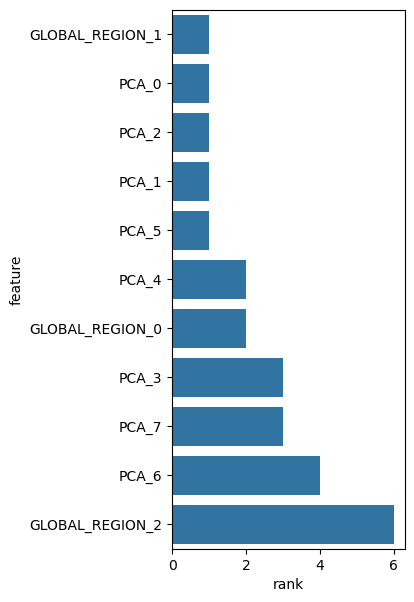

In [ ]:
plt.figure(figsize=(3, 7))
sns.barplot(plot_df, y = "feature", x = "rank", orient="h", order=order)

In [ ]:
weights_list = []

for X in X_list:
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('imputer', KNNImputer(n_neighbors=5)),
        ( 'pca', PCA(n_components=len(NUM_SELECTED)))
    ])

    numeric_transformer.fit(X_train[NUM_SELECTED])

    pca = numeric_transformer.named_steps['pca']

    # Get the explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_

    weights = pd.Series(explained_variance_ratio*100)

    weights_list.append(weights)

weights_df = pd.concat(weights_list, axis=1)

In [ ]:
plot_df = (
    weights_df
    .reset_index()
    .rename(columns={"index": "PCA Component"})
    .melt(id_vars="PCA Component", var_name="Fold", value_name="Explained Variance (%)")
)

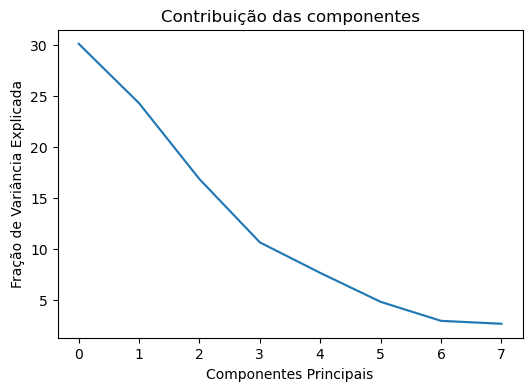

In [ ]:
# Plot the explained variance ratio
fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(plot_df, x="PCA Component", y="Explained Variance (%)", ax=ax, estimator='median')
ax.set_xlabel('Componentes Principais')
ax.set_ylabel('Fração de Variância Explicada')
ax.set_title('Contribuição das componentes')

plt.show()

In [ ]:
plot_df.groupby("PCA Component")["Explained Variance (%)"].mean().cumsum()

PCA Component
0     30.140872
1     54.441275
2     71.294811
3     81.941226
4     89.591694
5     94.400430
6     97.343026
7    100.000000
Name: Explained Variance (%), dtype: float64

In [36]:
#NUM_COMP = 4

#pca = PCA(n_components=NUM_COMP)
#PCA_COLS = [f'PCA{i+1}' for i in range(NUM_COMP)]

#X_pca_list = []

#for X in X_list:
#    X_pca = pca.fit_transform(X[NUM_SELECTED])
#    X_pca = pd.DataFrame(X_pca, columns=PCA_COLS, index=X.index)
#    X_pca_list.append(X_pca)

#X_test_pca = pca.transform(X_test[NUM_SELECTED])
#X_test_pca = pd.DataFrame(X_test_pca, columns=PCA_COLS, index=X_test.index)

In [37]:
#X_train_small_list = []

#for X_pca, X in zip(X_pca_list, X_list):
#    X_train_small = pd.concat([X_pca, X[CAT_SELECTED]], axis=1)
#    X_train_small_list.append(X_train_small)

#X_test_small = pd.concat([X_test_pca, X_test[CAT_SELECTED]], axis=1)

In [39]:
#for i, X_train_small in enumerate(X_train_small_list):
#    X_train_small.to_parquet(f"../../../../data/interim/copper/X_train_small/X_train_small_{i}.parquet")
    
#X_test_small.to_parquet('../../../../data/interim/copper/X_test_small.parquet')